In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: baharcakr
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 983MB/s]

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#pytorch doesn't detect gpu so we should define it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
data_df.dropna(inplace = True)
data_df.drop(['id'], axis=1, inplace=True)
#how many columns and rows
print(data_df.shape)

(18185, 11)


In [6]:
#for printing unique class row values which is 0 and 1 for this example
print(data_df["Class"].unique())

[1 0]


In [7]:
#for printing how many values are 0 and how many are 1
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [8]:
#make values smaller because NN values are usually smaller.
#copy the data to original for final inference.
original_df = data_df.copy()
for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [9]:
#split dataset
#take spesific part of the dataframe except the last one (class)
X = np.array(data_df.iloc[:,:-1])
#only the last one
Y = np.array(data_df.iloc[:,-1])

In [10]:
#split data into train test validation
#training 70% X is input Y is output
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

In [11]:
#create a validation set 15% test 15% validation (because we already splitted the test size in the previous snippet)
X_test,X_val,Y_test,Y_val = train_test_split(X,Y,test_size=0.5)

In [12]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(9093, 10)
(9092, 10)


In [13]:
#pre-defined functions and class in torch but modified to our dataset
class dataset(Dataset):
  def __init__(self, X,Y):
    #convert it to tensors for torch to understand move the value to device (gpu-cuda)
    self.X = torch.tensor(X,dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y,dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self,index):
    return self.X[index], self.Y[index]

In [14]:
training_data = dataset(X_train, Y_train)
validation_data = dataset(X_val, Y_val)
testing_data = dataset(X_test, Y_test)

In [24]:
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size = 32, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size = 32, shuffle=True)

In [25]:
for x, y in train_dataloader:
  print(x)
  print("=======")
  print(y)
  break

tensor([[0.6551, 0.8823, 0.6494, 0.9758, 0.6223, 0.8094, 0.5954, 0.6967, 0.7403,
         0.7708],
        [0.7636, 0.8169, 0.8182, 0.9230, 0.7265, 0.8738, 0.8368, 0.7058, 0.8407,
         0.5664],
        [0.6191, 0.8890, 0.6092, 0.9838, 0.5898, 0.7868, 0.8304, 0.7065, 0.6802,
         0.8279],
        [0.8301, 0.8391, 0.8630, 0.9166, 0.7973, 0.9111, 0.7670, 0.7338, 0.8455,
         0.5517],
        [0.6392, 0.7038, 0.7885, 0.8929, 0.6134, 0.7995, 0.7144, 0.6578, 0.8102,
         0.5064],
        [0.6307, 0.8887, 0.6271, 0.9807, 0.6057, 0.7941, 0.7343, 0.7094, 0.6873,
         0.8039],
        [0.7479, 0.7932, 0.8207, 0.9151, 0.7229, 0.8648, 0.7290, 0.6989, 0.8397,
         0.5483],
        [0.5235, 0.8471, 0.5346, 0.9917, 0.4983, 0.7235, 0.5570, 0.6565, 0.6662,
         0.8990],
        [0.5645, 0.7962, 0.6229, 0.9680, 0.5343, 0.7514, 0.5455, 0.6478, 0.7378,
         0.7252],
        [0.6770, 0.8919, 0.6645, 0.9743, 0.6414, 0.8228, 0.7738, 0.7137, 0.7289,
         0.7615],
        [0

In [26]:
HIDDEN_NEURONS=10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel,self).__init__()
    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.input_layer(x)
    x = self.linear(x)
    x=self.sigmoid(x)
    return x

model = MyModel().to(device)


In [27]:
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [28]:
#loss function
criterion = nn.BCELoss()
#optimizer Adam and learning rate
optimizer = Adam(model.parameters(), lr=1e-3)

In [29]:
#record after each epoch
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_dataloader:
    #forward prop
    inputs, labels=data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()
    acc=((prediction).round() == labels).sum().item()
    total_acc_train += acc
    #back prop
    batch_loss.backward()
    #change weights
    optimizer.step()
    #after changing weights optimizer starts again
    optimizer.zero_grad()

  #use torch for testing
  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction,labels)
      total_loss_val += batch_loss.item()
      acc=((prediction).round()==labels).sum().item()
      total_acc_val += acc
  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))
  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
  total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))
  print(f'''Epoch no. {epoch+1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy {round(total_acc_train/training_data.__len__() * 100 ,4)}
        Validation Loss: {round(total_loss_val/1000,4)} Validation Accuracy: {round(total_acc_val/validation_data.__len__() * 100, 4)}''')
  print("="*25)

Epoch no. 1 Train Loss: 0.2583 Train Accuracy 67.2323
        Validation Loss: 0.1484 Validation Accuracy: 97.9325
Epoch no. 2 Train Loss: 0.1354 Train Accuracy 97.5096
        Validation Loss: 0.0589 Validation Accuracy: 98.1084
Epoch no. 3 Train Loss: 0.0593 Train Accuracy 98.2088
        Validation Loss: 0.0318 Validation Accuracy: 98.2074
Epoch no. 4 Train Loss: 0.0363 Train Accuracy 98.4838
        Validation Loss: 0.0225 Validation Accuracy: 98.3834
Epoch no. 5 Train Loss: 0.0274 Train Accuracy 98.5388
        Validation Loss: 0.0182 Validation Accuracy: 98.7023
Epoch no. 6 Train Loss: 0.023 Train Accuracy 98.5152
        Validation Loss: 0.0155 Validation Accuracy: 98.7023
Epoch no. 7 Train Loss: 0.0204 Train Accuracy 98.5859
        Validation Loss: 0.0142 Validation Accuracy: 98.6583
Epoch no. 8 Train Loss: 0.0188 Train Accuracy 98.6409
        Validation Loss: 0.0132 Validation Accuracy: 98.7243
Epoch no. 9 Train Loss: 0.0177 Train Accuracy 98.6409
        Validation Loss: 0.

In [31]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss_test = criterion(prediction,labels).item()
    total_loss_test += batch_loss_test
    acc=((prediction).round()== labels).sum().item()
    total_acc_test += acc

print("Accuracy", round(total_acc_test/testing_data.__len__()*100,4))

Accuracy 98.5812


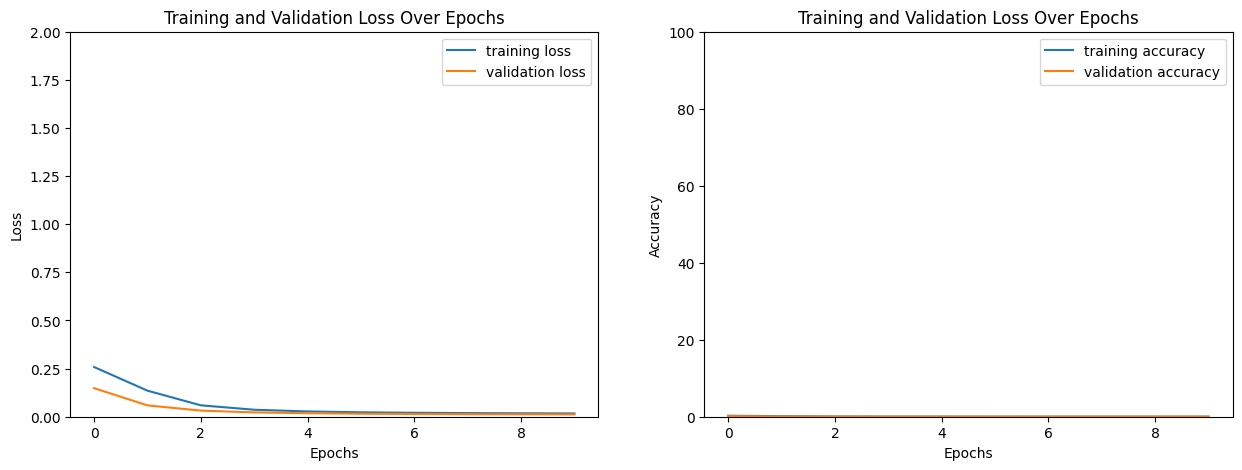

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label='training loss')
axs[0].plot(total_loss_validation_plot,label='validation loss')
axs[0].set_title("Training and Validation Loss Over Epochs")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_loss_train_plot, label='training accuracy')
axs[1].plot(total_loss_validation_plot,label='validation accuracy')
axs[1].set_title("Training and Validation Loss Over Epochs")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [42]:
Area = 2353/original_df['Area'].abs().max()
MajorAxisLength = 81/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = 42/original_df['MinorAxisLength'].abs().max()
Eccentricity = 32/original_df['Eccentricity'].abs().max()
ConvexArea = 12/original_df['ConvexArea'].abs().max()
EquivDiameter = 33/original_df['EquivDiameter'].abs().max()
Extent = 98/original_df['Extent'].abs().max()
Perimeter = 927/original_df['Perimeter'].abs().max()
Roundness= 677/original_df['Roundness'].abs().max()
AspectRation = 24/original_df['AspectRation'].abs().max()

my_prediction = model(torch.tensor([Area,MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent,Perimeter,Roundness,AspectRation], dtype=torch.float32).to(device))

In [44]:
my_prediction.item()

0.0